# Data

We will be analyzing an extract of 1994 U.S. Census data. See more data here：https://archive.ics.uci.edu/ml/datasets/census+income

# Goals

Work through the given data - cleaning it, exploring it, transforming it - so as to come to a point where we can build a model to predict whether or not a given citizen, based on the other available information, earns over $50K per year. Additionally, we will dive into learning the proper protocols for setting up for tuning, and evaluating, our predictive models.

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, chi2
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, make_scorer

from indoorplants.analysis import exploratory, wrangle
from indoorplants.validation import crossvalidate, curves

In [2]:
from scipy.spatial import distance

In [3]:
%matplotlib inline

## 1. Get Data

### Retrieve and quick look

In [4]:
def get_census_data():
    # column names
    cols = ['age', 'workclass', 'fnlwgt', 'education', 
            'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'sex', 'capital_gain',
            'capital_loss', 'hours_per_week', 'native_country', 
            'over_fifty_k']
    
    # url to retrieve data from
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    
    # iterate through lines of data stream, decoding and splitting each line on commas
    with requests.get(url, stream=True) as r:
        results = [l.decode().split(',') for l in r.iter_lines()]
    
    # convert data from of list of lists to DataFrame, set columns, and return
    return pd.DataFrame(results, columns=cols)

In [5]:
# retrieve data
table = get_census_data()

In [6]:
# check the size of data
table.shape

(32562, 15)

In [7]:
# check the data type
table.dtypes

age               object
workclass         object
fnlwgt            object
education         object
education_num     object
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain      object
capital_loss      object
hours_per_week    object
native_country    object
over_fifty_k      object
dtype: object

In [8]:
table.dtypes.value_counts()

object    15
dtype: int64

In [9]:
# quickly look the top and bottom of the table
table.iloc[:5, :7]

,age,workclass,fnlwgt,education,education_num,marital_status,occupation
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty


In [10]:
table.iloc[-5:, 8:]

,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
32557,White,Male,0,0,40,United-States,>50K
32558,White,Female,0,0,40,United-States,<=50K
32559,White,Male,0,0,20,United-States,<=50K
32560,White,Female,15024,0,40,United-States,>50K
32561,None,None,None,None,None,None,None


## Data cleanliness

In [11]:
# check the missing value
table.isnull().sum()

age               0
workclass         1
fnlwgt            1
education         1
education_num     1
marital_status    1
occupation        1
relationship      1
race              1
sex               1
capital_gain      1
capital_loss      1
hours_per_week    1
native_country    1
over_fifty_k      1
dtype: int64

In [12]:
table.isnull().head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [13]:
table.age.isnull().head()

0    False
1    False
2    False
3    False
4    False
Name: age, dtype: bool

In [14]:
table.notnull().all(axis = 1).tail()

32557     True
32558     True
32559     True
32560     True
32561    False
dtype: bool

In [15]:
# find the missing value index
table[table.isnull().any(1)].index

Int64Index([32561], dtype='int64')

In [16]:
# before dorping missing data
table.loc[32561,"age"]

''

In [17]:
#drop data
table = table.drop(32561)

In [18]:
# check for duplicates
table.duplicated().sum()

24

In [19]:
table[table.duplicated(keep = False)].to_csv("duplicated.csv")

In [20]:
table = table.drop_duplicates()

# Data type handling - _numeric_

In [21]:
# check the numeric columns
table[["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [22]:
# save columns for future use
numeric_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

In [23]:
# check the "." in numeric columns
[(col, table[col].str.contains("\.").sum()) for col in numeric_cols]

[('age', 0),
 ('fnlwgt', 0),
 ('education_num', 0),
 ('capital_gain', 0),
 ('capital_loss', 0),
 ('hours_per_week', 0)]

In [24]:
table[numeric_cols].head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [25]:
table[numeric_cols] = table[numeric_cols].astype(int)

In [26]:
table.loc[:, numeric_cols].astype(int).dtypes

age               int32
fnlwgt            int32
education_num     int32
capital_gain      int32
capital_loss      int32
hours_per_week    int32
dtype: object

In [27]:
table.dtypes

age                int32
workclass         object
fnlwgt             int32
education         object
education_num      int32
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int32
capital_loss       int32
hours_per_week     int32
native_country    object
over_fifty_k      object
dtype: object

# Data type handling - *boolean*

In [28]:
# see how many values in data now
table.over_fifty_k.apply(lambda val: 1 if val == '>50K'else 0).value_counts()

0    32537
Name: over_fifty_k, dtype: int64

In [29]:
# see all unique values in over_fifty_k column
table.over_fifty_k.unique()

array([' <=50K', ' >50K'], dtype=object)

In [30]:
table.over_fifty_k = table.over_fifty_k.str.strip()

In [31]:
(table.age >= 30).head(10)

0     True
1     True
2     True
3     True
4    False
5     True
6     True
7     True
8     True
9     True
Name: age, dtype: bool

In [32]:
# see how many citizens earn over 50k 
table.over_fifty_k.value_counts()

<=50K    24698
>50K      7839
Name: over_fifty_k, dtype: int64

In [33]:
table['over_fifty_k_bool'] = table.over_fifty_k == ' >50K'

In [34]:
table.over_fifty_k.apply(lambda _: True if _ == '>50K'else False).value_counts(normalize=True)

False    0.759074
True     0.240926
Name: over_fifty_k, dtype: float64

In [35]:
table.over_fifty_k = table.over_fifty_k.apply(lambda _: True if _ == '>50K'else False)

# Data type handling

In [36]:
table.dtypes.value_counts()

object    8
int32     6
bool      2
dtype: int64

In [37]:
table.dtypes

age                   int32
workclass            object
fnlwgt                int32
education            object
education_num         int32
marital_status       object
occupation           object
relationship         object
race                 object
sex                  object
capital_gain          int32
capital_loss          int32
hours_per_week        int32
native_country       object
over_fifty_k           bool
over_fifty_k_bool      bool
dtype: object

In [38]:
# view columns by data type
table.select_dtypes(include = [int]).head()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,39,77516,13,2174,0,40
1,50,83311,13,0,0,13
2,38,215646,9,0,0,40
3,53,234721,7,0,0,40
4,28,338409,13,0,0,40


In [39]:
table.select_dtypes(exclude = [object,int]).head()

,over_fifty_k,over_fifty_k_bool
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [40]:
# check for space included in object columns
[(col, table[col].str.contains(" ").sum()) 
 for col in table.select_dtypes(include=[object]).columns]

[('workclass', 32537),
 ('education', 32537),
 ('marital_status', 32537),
 ('occupation', 32537),
 ('relationship', 32537),
 ('race', 32537),
 ('sex', 32537),
 ('native_country', 32537)]

In [41]:
# removing trailing and leading spaces
for col in table.select_dtypes(include=[object]).columns:
    table[col] = table[col].str.strip()

In [42]:
# recheck for space
[(col, table[col].str.contains(" ").sum()) 
 for col in table.select_dtypes(include=[object]).columns]

[('workclass', 0),
 ('education', 0),
 ('marital_status', 0),
 ('occupation', 0),
 ('relationship', 0),
 ('race', 0),
 ('sex', 0),
 ('native_country', 0)]

# 2.Exploratory Data Analysis

## Numeric columns - distributional analysis

In [43]:
# see the number of unique age values
table.age.nunique()

73

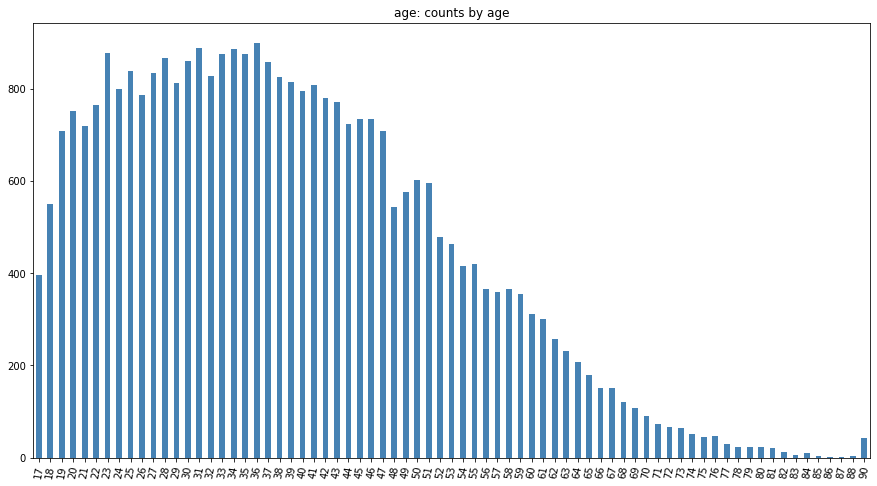

In [44]:
# plot for different age distribution
ax = table.age.value_counts().sort_index().plot.bar(figsize=(15, 8), color="steelblue", rot=80)
ax.title.set_text('age: counts by age')

In [45]:
# descriptive stats for deviding citizens by age
table.age.describe()

count    32537.000000
mean        38.585549
std         13.637984
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [46]:
table.age.mean()

38.585548759873376

We could easily find that the mean which arounds 39 is larger than the median 37 (the 50% of the data). So the data distribution is positive skew. Besides, the range of age is from 17 to 90.

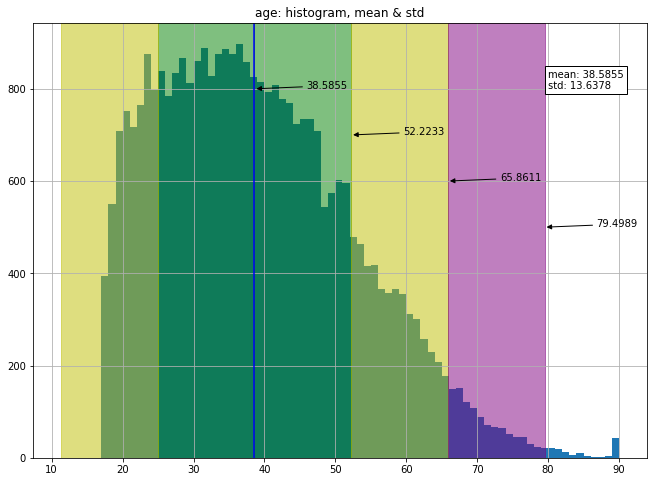

In [47]:
ax = exploratory.center_scale_plot(table.age, np.mean, np.std, bins=73)

In [48]:
# set the 5 as age interval
def age_around(x, base = 5):
    return (base * round(x.astype(float)/base)).astype(int)

In [49]:
# now see the first 10 citizens age level
age_around(table.age).head(10)

0    40
1    50
2    40
3    55
4    30
5    35
6    50
7    50
8    30
9    40
Name: age, dtype: int32

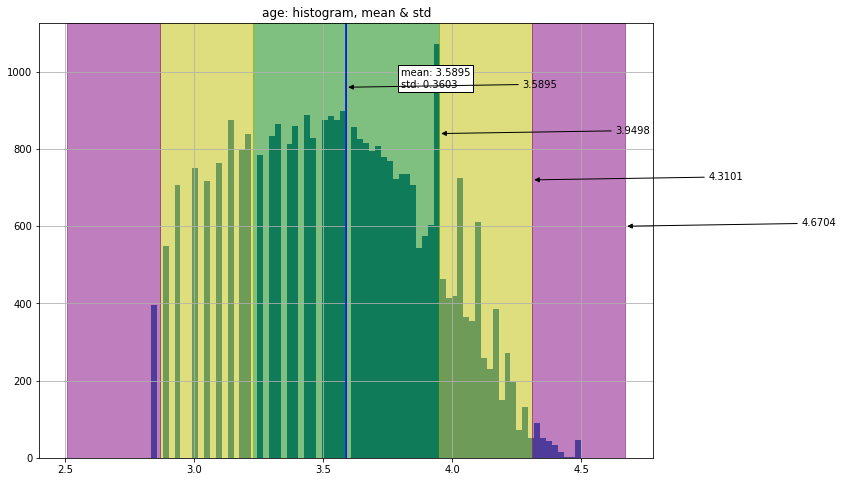

In [50]:
ax = exploratory.center_scale_plot(np.log(table.age), np.mean, np.std, bins=73)

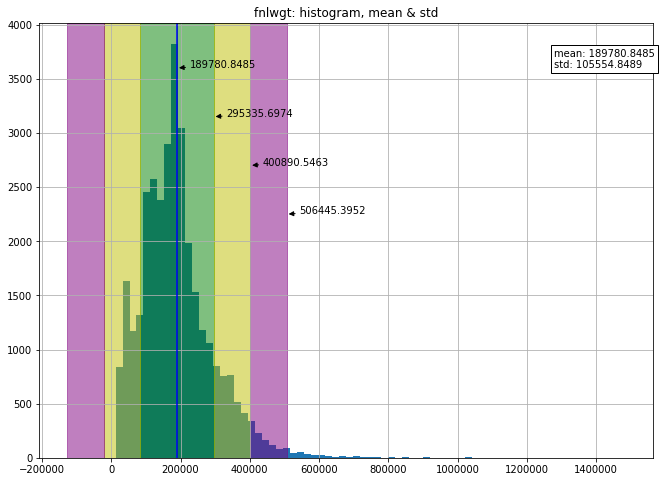

In [51]:
# now let's see the wages distribution
ax = exploratory.center_scale_plot(table.fnlwgt, np.mean, np.std, bins=73)

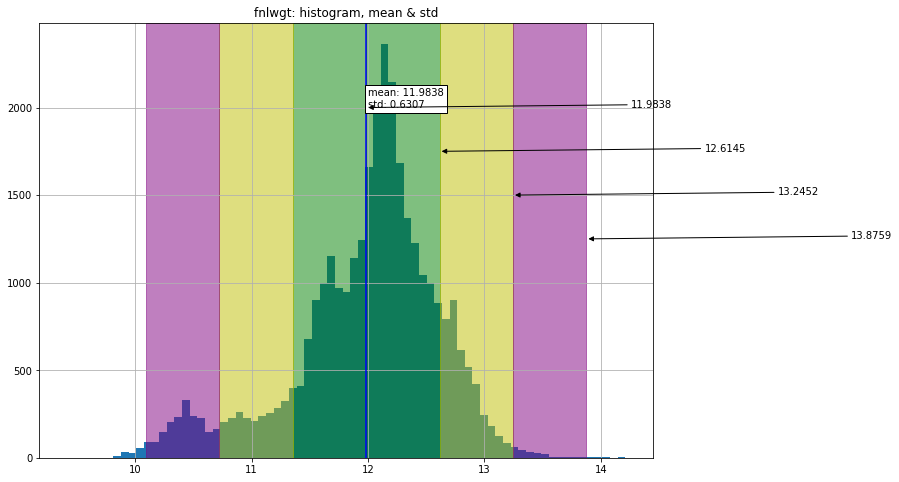

In [52]:
ax = exploratory.center_scale_plot(np.log(table.fnlwgt), np.mean, np.std, bins=73)

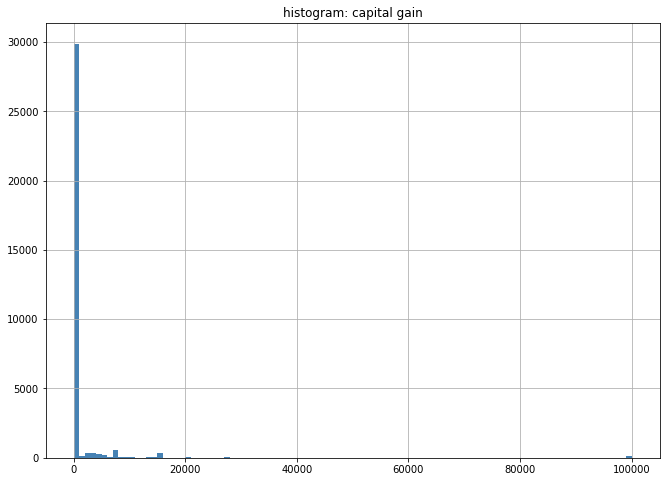

In [53]:
#Use histogram take a look at a continuous column: capital_gain.
ax = table.capital_gain.hist(figsize=(11, 8), color="steelblue", bins=100)
ax.title.set_text("histogram: capital gain")

In [54]:
# check how many capital gain more than 0
(table.capital_gain > 0).sum()

2712

In [55]:
(table.capital_gain > 0).sum()/len(table)

0.08335126164059378

We find here are 2712 citizens capital gain more than 0, less than 10% of data. Then we want to check the capital loss if have the same problem

In [56]:
# describe stats for capital loss
table.capital_loss.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
capital_loss,32537.0,87.368227,403.101833,0.0,0.0,0.0,0.0,4356.0


In [57]:
# check how many capital loss more than 0
(table.capital_loss > 0).sum()

1519

In [58]:
(table.capital_loss > 0).sum()/len(table)

0.046685312106217534

In [59]:
((table.capital_gain > 0) & (table.capital_loss > 0)).sum()

0

In [60]:
((table.capital_gain > 0) | (table.capital_loss > 0)).sum()

4231

In [61]:
# create new column to describe net capital gains 
table["capital_gain_net"] = table.capital_gain - table.capital_loss

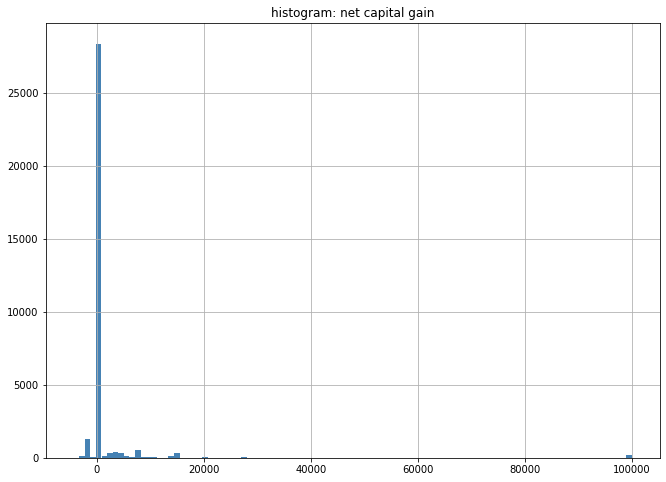

In [62]:
ax = table.capital_gain_net.hist(figsize=(11, 8), color="steelblue", bins=100)
ax.title.set_text("histogram: net capital gain")

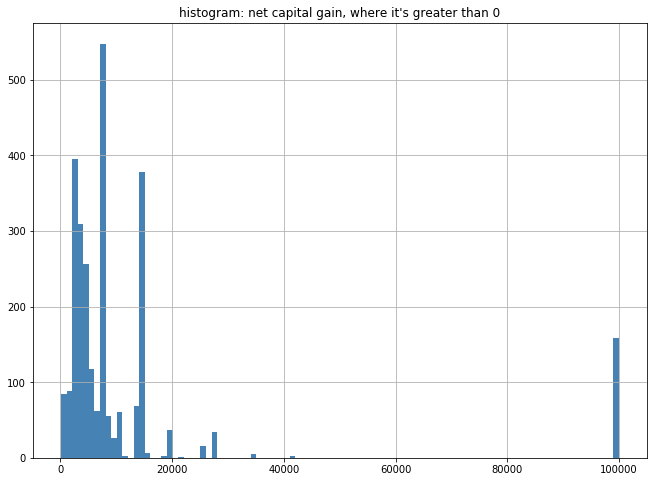

In [63]:
# view the net capital gains greater than 0
ax = table.loc[table.capital_gain_net > 0, "capital_gain_net"
              ].hist(figsize=(11, 8), 
                     color="steelblue", bins=100)

ax.title.set_text("histogram: net capital gain, where it's greater than 0")

In [64]:
# for net capital gains more than 0, create a new column
table["is_capital_gain_nonzero"] = table.capital_gain.apply(lambda x: x > 0)

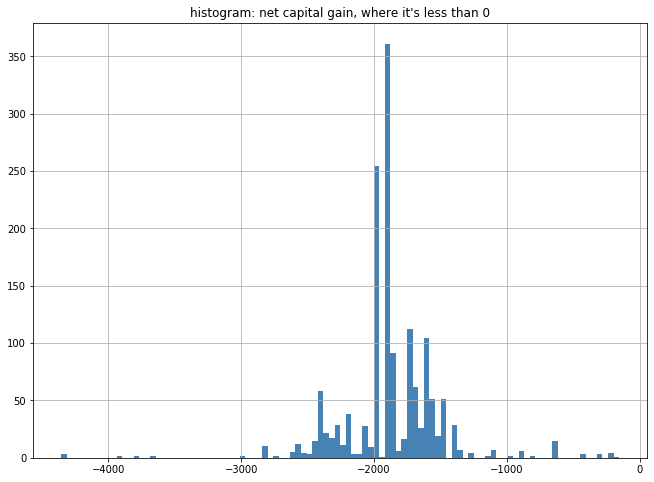

In [65]:
# view the net capital loss less than 0
ax = table.loc[table.capital_gain_net < 0, "capital_gain_net"
              ].hist(figsize=(11, 8), 
                     color="steelblue", bins=100)

ax.title.set_text("histogram: net capital gain, where it's less than 0")

In [66]:
# for net capital loss less than 0, create a new column
table["is_capital_loss_nonzero"] = table.capital_loss.apply(lambda x: x < 0)

## Multivariate analysis —— *group by*

In [67]:
# average capital gain when income is over $50K vs. when it's not
table[["over_fifty_k", "capital_gain"]].groupby("over_fifty_k").mean()

,capital_gain
over_fifty_k,
False,148.884970
True,4007.164562


In [68]:
table[["over_fifty_k_bool", "capital_gain"]
      ].groupby("over_fifty_k_bool"
      ).agg(["mean", "std"])


capital_gain             
                          mean          std
over_fifty_k_bool                          
False              1078.443741  7387.957424

In [69]:
# saving previous result as a new variable
_cap_gains_means = table[["over_fifty_k", "capital_gain"]
                        ].groupby("over_fifty_k").mean()

In [70]:
_cap_gains_means.columns

Index(['capital_gain'], dtype='object')

In [71]:
# rename column for avoiding ambiguity
_cap_gains_means = _cap_gains_means.rename(columns={"capital_gain": "capital_gain_mean"})

In [72]:
# create standard deviation
_cap_gains_std = table[["over_fifty_k", "capital_gain"]
                        ].groupby("over_fifty_k").std()

In [73]:
_cap_gains_std = _cap_gains_std.rename(columns={"capital_gain": "capital_gain_std"})

In [74]:
# join tables
_cap_gains_means.join(_cap_gains_std)

,capital_gain_mean,capital_gain_std
over_fifty_k,,
False,148.884970,963.557955
True,4007.164562,14572.097223


For higher income citizens, they have higher average capital gains, but with much more volatility. 

In [75]:
_cap_gains_joined = _cap_gains_means.join(_cap_gains_std)

In [76]:
_cap_gains_joined["cap_gains_ratio"] = _cap_gains_joined.capital_gain_std / _cap_gains_joined.capital_gain_mean

In [77]:
_cap_gains_joined

,capital_gain_mean,capital_gain_std,cap_gains_ratio
over_fifty_k,,,
False,148.884970,963.557955,6.471828
True,4007.164562,14572.097223,3.636511


proportionately, the low-income folks have more volatility.

In [78]:
# drop non-related column
table = table.drop("education_num", axis=1)

In [79]:
# define function for capital gain
def get_group_by_stats(df, col_to_group_by, col_to_group):
    means = df[[col_to_group_by, col_to_group]
               ].groupby(col_to_group_by).mean()
    
    means = means.rename(columns={col_to_group: f"{col_to_group}_mean"})
    
    stds = df[[col_to_group_by, col_to_group]
               ].groupby(col_to_group_by).std()
    
    stds = stds.rename(columns={col_to_group: f"{col_to_group}_std"})
    
    joined = means.join(stds)
    joined[f"{col_to_group}_ratio"] = joined[f"{col_to_group}_std"] / joined[f"{col_to_group}_mean"]
    
    return joined


In [80]:
get_group_by_stats(table, "over_fifty_k", "capital_gain")

,capital_gain_mean,capital_gain_std,capital_gain_ratio
over_fifty_k,,,
False,148.884970,963.557955,6.471828
True,4007.164562,14572.097223,3.636511


In [81]:
# generate a list for columns
_df_list = [get_group_by_stats(table, "over_fifty_k", col)
            for col in table.select_dtypes(include=[int, float]).columns]

In [82]:
_df_list[0].join(_df_list[1:]).T

over_fifty_k,False,True
age_mean,36.787392,44.250925
age_std,14.017335,10.520102
age_ratio,0.381036,0.237737
fnlwgt_mean,190345.926796,188000.480674
fnlwgt_std,106487.413197,102554.464101
fnlwgt_ratio,0.559442,0.545501
capital_gain_mean,148.884970,4007.164562
capital_gain_std,963.557955,14572.097223
capital_gain_ratio,6.471828,3.636511
capital_loss_mean,53.190258,195.051282


In [83]:
# save results
_combined = _df_list[0].join(_df_list[1:]).T

In [84]:
_combined.columns

Index([False, True], dtype='object', name='over_fifty_k')

In [85]:
# map the columns
_combined.columns = list(map(lambda x: str(x) + "_", _combined.columns))

In [86]:
# calculate standard deviation
_combined["std"] = _combined.std(axis=1)

In [87]:
# aggrate the mean
_combined_filtered = _combined.loc[_combined.index.str.endswith("mean")]

In [88]:
# sort by standard
_combined_filtered.sort_values("std", ascending=False).iloc[:10]

,False_,True_,std
capital_gain_mean,148.884970,4007.164562,2728.215663
capital_gain_net_mean,95.694712,3812.113280,2627.904771
fnlwgt_mean,190345.926796,188000.480674,1658.480858
capital_loss_mean,53.190258,195.051282,100.310892
age_mean,36.787392,44.250925,5.277515
hours_per_week_mean,38.842862,45.473402,4.688500


## Multivariate analysis - *cross tabulations*

In [89]:
# view the salary distribution by marital status
pd.crosstab(table.over_fifty_k, table.marital_status).T

over_fifty_k,False,True
marital_status,,
Divorced,3978,463
Married-AF-spouse,13,10
Married-civ-spouse,8280,6690
Married-spouse-absent,384,34
Never-married,10176,491
Separated,959,66
Widowed,908,85


In [90]:
# save the result
_cross_tabs = pd.crosstab(table.over_fifty_k, table.marital_status).T

In [91]:
_cross_tabs = _cross_tabs / len(table)

In [92]:
_cross_tabs.sum().sum()

1.0

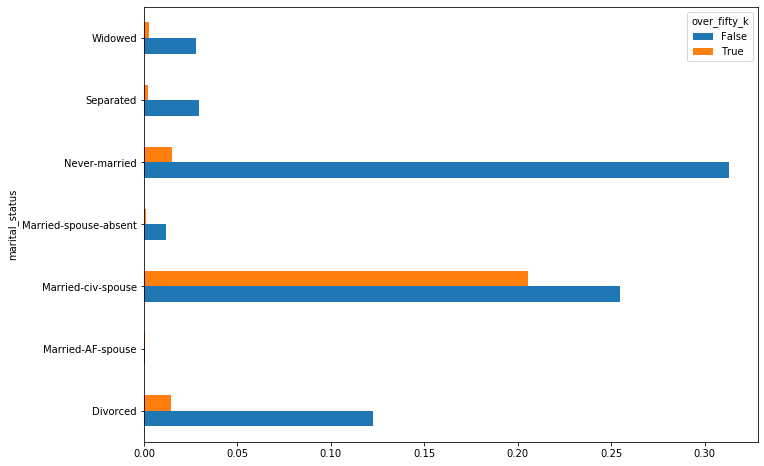

In [93]:
# visualization
ax = _cross_tabs.plot.barh(figsize=(11, 8))

In [94]:
# tabulate columns
table[["over_fifty_k", "marital_status", "sex"]
     ].groupby(["over_fifty_k", "marital_status", "sex"]
     ).size()

over_fifty_k  marital_status         sex   
False         Divorced               Female    2491
                                     Male      1487
              Married-AF-spouse      Female       8
                                     Male         5
              Married-civ-spouse     Female     903
                                     Male      7377
              Married-spouse-absent  Female     194
                                     Male       190
              Never-married          Female    4594
                                     Male      5582
              Separated              Female     614
                                     Male       345
              Widowed                Female     779
                                     Male       129
True          Divorced               Female     179
                                     Male       284
              Married-AF-spouse      Female       6
                                     Male         4
              Marrie

In [95]:
_multi_tab = table[["over_fifty_k", "marital_status", "sex"]
                     ].groupby(["over_fifty_k", "marital_status", "sex"]
                     ).size().rename("size")

In [96]:
_multi_tab.unstack()

sex                                 Female  Male
over_fifty_k marital_status                     
False        Divorced                 2491  1487
             Married-AF-spouse           8     5
             Married-civ-spouse        903  7377
             Married-spouse-absent     194   190
             Never-married            4594  5582
             Separated                 614   345
             Widowed                   779   129
True         Divorced                  179   284
             Married-AF-spouse           6     4
             Married-civ-spouse        754  5936
             Married-spouse-absent      11    23
             Never-married             166   325
             Separated                  17    49
             Widowed                    46    39

In [97]:
# change the level to pop out
_multi_tab.unstack(0)

over_fifty_k                  False  True 
marital_status        sex                 
Divorced              Female   2491    179
                      Male     1487    284
Married-AF-spouse     Female      8      6
                      Male        5      4
Married-civ-spouse    Female    903    754
                      Male     7377   5936
Married-spouse-absent Female    194     11
                      Male      190     23
Never-married         Female   4594    166
                      Male     5582    325
Separated             Female    614     17
                      Male      345     49
Widowed               Female    779     46
                      Male      129     39

In [98]:
_multi_tab.unstack(0).stack()

marital_status         sex     over_fifty_k
Divorced               Female  False           2491
                               True             179
                       Male    False           1487
                               True             284
Married-AF-spouse      Female  False              8
                               True               6
                       Male    False              5
                               True               4
Married-civ-spouse     Female  False            903
                               True             754
                       Male    False           7377
                               True            5936
Married-spouse-absent  Female  False            194
                               True              11
                       Male    False            190
                               True              23
Never-married          Female  False           4594
                               True             166
                    

# 3. Feature Selection

In [99]:
# set train and test parts
train_inds, test_inds = train_test_split(
    table.index, test_size=.1, stratify=table.over_fifty_k)

In [100]:
table_train = table.loc[train_inds, 
            [c for c in table.columns if c != "over_fifty_k"]]

In [101]:
table_train

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,over_fifty_k_bool,capital_gain_net,is_capital_gain_nonzero,is_capital_loss_nonzero
28314,45,Self-emp-not-inc,220978,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,False,0,False,False
17860,22,Private,197838,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Male,0,0,40,United-States,False,0,False,False
2424,61,Private,83045,9th,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,False,0,False,False
30179,21,Self-emp-not-inc,74538,Some-college,Never-married,Tech-support,Not-in-family,White,Male,0,0,25,United-States,False,0,False,False
15774,39,Private,33983,Some-college,Married-civ-spouse,Adm-clerical,Husband,White,Male,15024,0,40,United-States,False,15024,True,False
23384,31,Federal-gov,166626,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,False,0,False,False
8967,38,Local-gov,421446,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,50,United-States,False,0,False,False
22159,26,Private,159759,Bachelors,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,False,0,False,False
4767,21,Private,250051,Some-college,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,False,0,False,False
29502,25,Local-gov,476599,Bachelors,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,False,0,False,False


In [102]:
fifty_k_train = table.loc[train_inds, "over_fifty_k"]

## Feature Selection

In [103]:
# drop redundancy columns
table_train = table_train.drop(["capital_gain", "capital_loss", 
                               "is_capital_loss_nonzero", "fnlwgt"], axis=1)

In [104]:
table_train

,age,workclass,education,marital_status,occupation,relationship,race,sex,hours_per_week,native_country,over_fifty_k_bool,capital_gain_net,is_capital_gain_nonzero
28314,45,Self-emp-not-inc,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,50,United-States,False,0,False
17860,22,Private,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Male,40,United-States,False,0,False
2424,61,Private,9th,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,False,0,False
30179,21,Self-emp-not-inc,Some-college,Never-married,Tech-support,Not-in-family,White,Male,25,United-States,False,0,False
15774,39,Private,Some-college,Married-civ-spouse,Adm-clerical,Husband,White,Male,40,United-States,False,15024,True
23384,31,Federal-gov,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,40,United-States,False,0,False
8967,38,Local-gov,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Black,Male,50,United-States,False,0,False
22159,26,Private,Bachelors,Never-married,Other-service,Own-child,White,Male,40,United-States,False,0,False
4767,21,Private,Some-college,Never-married,Prof-specialty,Own-child,White,Female,10,United-States,False,0,False
29502,25,Local-gov,Bachelors,Never-married,Prof-specialty,Not-in-family,White,Female,40,United-States,False,0,False


In [105]:
table_train.sex.head()

28314    Male
17860    Male
2424     Male
30179    Male
15774    Male
Name: sex, dtype: object

In [106]:
# get dummy variables
pd.get_dummies(table_train.sex.head())

,Male
28314,1
17860,1
2424,1
30179,1
15774,1


In [107]:
_one_hots = [pd.get_dummies(
                table_train[col], drop_first=True, prefix=col)
             for col in table_train.select_dtypes(include=object
                                                 ).columns]

In [108]:
_one_hots[0].iloc[:3, :3]

,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked
28314,0,0,0
17860,0,0,0
2424,0,0,0


In [109]:
one_hot_df = _one_hots[0].join(_one_hots[1:])

In [110]:
one_hot_df.shape

(29283, 94)

In [111]:
# create target variable and independent variables
X = one_hot_df.join(table_train.select_dtypes(
                        include=[int, bool]))

In [112]:
X.shape

(29283, 99)

In [113]:
table_train.dtypes.value_counts()

object    8
int32     3
bool      2
dtype: int64

In [114]:
y = fifty_k_train

In [115]:
# create RFC
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

In [116]:
selector = RFE(rf, 10)

In [117]:
selector.fit(X, y)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=10, n_jobs=None,
                                     oob_score=False, random_state=None,
                                     verbose=0, warm_start=False),
    n_features_to_select=10, step=1, verbose=0)

In [118]:
sorted(list(X.columns[selector.support_]))

['age',
 'capital_gain_net',
 'education_Bachelors',
 'hours_per_week',
 'is_capital_gain_nonzero',
 'marital_status_Married-civ-spouse',
 'marital_status_Never-married',
 'occupation_Exec-managerial',
 'occupation_Prof-specialty',
 'sex_Male']

In [119]:
ranks = pd.DataFrame(
    list(zip(X.columns, selector.ranking_)), 
    columns=["column_name", "rank_survived_until"]
                     ).sort_values("rank_survived_until")

In [120]:
ranks.iloc[10:20]

,column_name,rank_survived_until
18,education_HS-grad,2
3,workclass_Private,3
22,education_Some-college,4
51,race_White,5
36,occupation_Other-service,6
91,native_country_United-States,7
43,relationship_Not-in-family,8
5,workclass_Self-emp-not-inc,9
19,education_Masters,10
31,occupation_Craft-repair,11


In [121]:
ranks.iloc[-10:]

,column_name,rank_survived_until
86,native_country_Scotland,81
7,workclass_Without-pay,82
77,native_country_Laos,83
80,native_country_Outlying-US(Guam-USVI-etc),84
30,occupation_Armed-Forces,85
89,native_country_Thailand,86
68,native_country_Honduras,87
2,workclass_Never-worked,88
67,native_country_Holand-Netherlands,89
96,over_fifty_k_bool,90


They are bad classifiers. Might make RFC overfit.

In [122]:
crummy_features = ranks.iloc[-10:].index

In [123]:
# view which features are important
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

In [124]:
# fit model to data
rf = rf.fit(X, y)

In [125]:
importances = pd.DataFrame(list(zip(X.columns, rf.feature_importances_)), 
                           columns=["column_name", "importance"])

In [126]:
importances.sort_values("importance", ascending=False
                       ).iloc[:10
                       ].sort_values("column_name")

,column_name,importance
94,age,0.219799
97,capital_gain_net,0.069307
18,education_HS-grad,0.020125
95,hours_per_week,0.111371
98,is_capital_gain_nonzero,0.022984
24,marital_status_Married-civ-spouse,0.068425
26,marital_status_Never-married,0.108933
32,occupation_Exec-managerial,0.032102
43,relationship_Not-in-family,0.020782
52,sex_Male,0.021019


In [127]:
X.shape

(29283, 99)

# 3. Machine Learning

## Class Imbalance

In [128]:
def crummy_model(X):
    return np.zeros((len(X),))

In [129]:
y_pred = crummy_model(X)

In [130]:
accuracy_score(y, y_pred)

0.7590752313629068

## Scores

In [131]:
# confusion matrix
def get_confusion(y, y_true):
    matrix = confusion_matrix(y, y_true)
    
    df = pd.DataFrame(matrix,
                     index=["negative_actual", "positive_actual"],
                     columns=["negative_predicted", "positive_predicted"])
    
    return df

In [132]:
get_confusion(y, y_pred)

,negative_predicted,positive_predicted
negative_actual,22228,0
positive_actual,7055,0


## cross validation

In [133]:
rf = RandomForestClassifier(n_estimators=10, class_weight="balanced")

In [134]:
# accuracy
accs = cross_val_score(rf, X, y, 
                       scoring=make_scorer(accuracy_score), cv=5)

In [135]:
np.mean(accs), np.std(accs)

(0.8379606603093211, 0.002472056662647395)

In [136]:
# precision score
precs = cross_val_score(rf, X, y, 
                        scoring=make_scorer(precision_score), cv=5)

In [137]:
np.mean(precs), np.std(precs)

(0.6863284472758112, 0.005967525207635552)

In [138]:
# recall score
recs = cross_val_score(rf, X, y, 
                       scoring=make_scorer(recall_score), cv=5)

In [139]:
np.mean(recs), np.std(recs)

(0.6021261516654854, 0.016858534102232613)

## Hyper-parameter tuning

In [140]:
# control depth of the tree
results = cross_validate(rf, X, y, 
                         scoring=make_scorer(recall_score), 
                         cv=5, return_train_score=True)

In [141]:
results_train = pd.Series(results["train_score"], name="train")

In [142]:
results_test= pd.Series(results["test_score"], name="test")

In [143]:
results_train.to_frame().join(results_test)

,train,test
0,0.935507,0.593905
1,0.938873,0.603827
2,0.941176,0.622962
3,0.942062,0.574061
4,0.937101,0.600992


In [144]:
rf_depth = RandomForestClassifier(n_estimators=10, 
                                  class_weight="balanced", 
                                  max_depth=16)

In [145]:
results = cross_validate(rf_depth, X, y, scoring=make_scorer(recall_score), cv=5, return_train_score=True)

In [146]:
results_train = pd.Series(results["train_score"], name="train")

In [147]:
results_test= pd.Series(results["test_score"], name="test")

In [148]:
results_train.to_frame().join(results_test)

,train,test
0,0.920092,0.838412
1,0.920978,0.852587
2,0.916549,0.850461
3,0.918852,0.851878
4,0.918143,0.844082


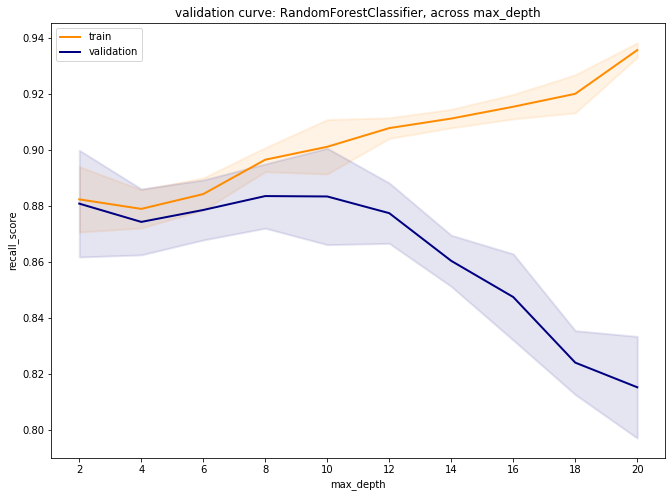

In [149]:
curves.validation_curve(X, y,
                        score=recall_score,
                        model_type=RandomForestClassifier,
                        param_name="max_depth",
                        param_range=[2*n for n in range(1, 11)],
                        other_params={"n_estimators": 10, 
                                      "class_weight": "balanced"})

## Final performance estimation

In [150]:
table_test = table.loc[test_inds, [c for c in table.columns if c != "over_fifty_k"]]

In [151]:
fifty_k_test = table.loc[test_inds, "over_fifty_k"]

In [152]:
table_test = table_test.drop(["capital_gain", "capital_loss", 
                               "is_capital_loss_nonzero", "fnlwgt"], axis=1)

In [153]:
_one_hots = [pd.get_dummies(table_test[col], drop_first=True, prefix=col)
             for col in table_test.select_dtypes(include=object).columns]

In [154]:
one_hot_df_test = _one_hots[0].join(_one_hots[1:])

In [155]:
one_hot_df_test.shape

(3254, 92)

In [156]:
X_test = one_hot_df_test.join(table_test.select_dtypes(include=[int, float]))

In [157]:
X_test.shape

(3254, 95)

In [158]:
table_test.dtypes.value_counts()

object    8
int32     3
bool      2
dtype: int64

In [159]:
y_test = fifty_k_test

In [160]:
y_test

4363     False
31244     True
4769     False
1003     False
16474     True
31775     True
31781    False
3415     False
30751    False
8736     False
24749     True
2840      True
11336    False
18743    False
16884    False
12152     True
14941    False
10708     True
13353     True
32194    False
11518    False
27488    False
15675    False
20280    False
17436     True
24072     True
17301    False
1245     False
16224    False
27571    False
         ...  
4034     False
22940    False
6632     False
3165     False
27496    False
15589    False
30712    False
24515    False
7222      True
21154    False
25717    False
14444    False
1158     False
11254     True
27188     True
19207    False
17622     True
10204    False
25247    False
5333     False
15017    False
32473    False
17149    False
22582    False
16778     True
16460     True
31210    False
1237     False
27211    False
22012    False
Name: over_fifty_k, Length: 3254, dtype: bool